In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neural_network import BernoulliRBM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time
import torchvision.transforms as transforms
from sklearn.datasets import fetch_openml
import numpy as np
import torch
from PIL import Image

In [53]:
# Load MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X,y = mnist.data, mnist.target.astype(int)

In [5]:
y

array([5, 0, 4, ..., 4, 5, 6], shape=(70000,))

In [ ]:
# filtering only for 0s and 1s
mask = (y==0) | (y==1)
X_binary = X[mask]
y_binary = y[mask]

print(f"Org MNIST size: {X.shape[0]} samples")
print(f"Filtered: {X_binary.shape[0]} samples")
print(f"Number of 0s: {np.sum(y_binary == 0)}")
print(f"Number of 1s: {np.sum(y_binary == 1)}")

Org MNIST size: 70000 samples
Filtered: 14780 samples
Number of 0s: 6903
Number of 1s: 7877


In [56]:
# normalization to [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_binary)

In [57]:
# thresholding on 0.5 to convert to 0 or 1
X_binarized = (X_scaled > 0.5).astype(np.float32)

In [58]:
# w/o normalization pseudolikelihood is huge
X_binarized

array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 1.],
       [0., 1., 1., ..., 0., 1., 1.],
       ...,
       [0., 1., 1., ..., 1., 0., 1.],
       [1., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]], shape=(14780, 144), dtype=float32)

In [59]:
#Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_binarized, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

In [60]:
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 11824
Test set size: 2956


In [41]:
# initialize BernoulliRBM
rbm = BernoulliRBM(n_components = 20, learning_rate = 0.01, batch_size=16, n_iter=150, verbose=1,random_state=42)

# Parameters are estimated using SML (Persistent CD). Time Complexity: O(n**2)
# n_components: int, def=256 Number of binary hidden units
# learning_rate: float, def =0.1 (tune this --> [1,0.001]
# batch_size: int, def = 10 Number of exapmles per minibatch
# n_iter: int, def=10 Number of iter over the training dataset
# verbose: int, def=0 0 is silent mode --> [0, inf)
# random_state: int, def=None RNG for Gibbs sampling from hidden and visible layers, sampling from layers or corrupting the data

In [43]:
# Train RBM
start_time = time.time()
rbm.fit(X_train)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} secs")

[BernoulliRBM] Iteration 1, pseudo-likelihood = -233.91, time = 0.40s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -191.41, time = 0.33s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -189.54, time = 0.34s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -189.43, time = 0.33s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -189.26, time = 0.32s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -188.98, time = 0.34s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -189.42, time = 0.31s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -189.07, time = 0.35s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -189.22, time = 0.34s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -189.29, time = 0.35s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -189.22, time = 0.34s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -189.16, time = 0.39s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -189.00, time = 0.42s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -188.94, time = 0.46s
[BernoulliRBM] 

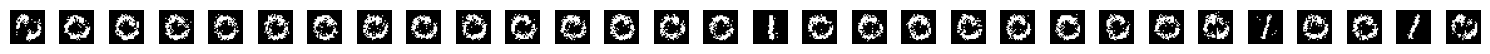

In [45]:
# Generating samples
def generate_samples(rbm, n_samples = 30, n_gibbs_steps = 20):
    random_data = np.random.rand(n_samples, rbm.components_.shape[1]) # random init. of visible nodes
    v = (random_data > 0.5).astype(np.float32)

    for step in range(n_gibbs_steps):
        v = rbm.gibbs(v)
    
    return v


# Generate samples
samples = generate_samples(rbm, n_samples=30, n_gibbs_steps=100)

#Plot
fig, axes = plt.subplots(1, 30, figsize=(15,3))
for i, ax in enumerate(axes):
    ax.imshow(samples[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [14]:
# stats
print(f"No. of hidden units: {rbm.n_components}")
print(f"Training score (pseudo-likelihood): {rbm.score_samples(X_train[:1000]).mean():.4f}")
print(f"Test score (pseudo-likelihood): {rbm.score_samples(X_test[:1000]).mean():.4f}")

No. of hidden units: 64
Training score (pseudo-likelihood): -56.0463
Test score (pseudo-likelihood): -55.2335


In [15]:
# start with gibbs(v) with 0s and 1s. Run gibbs a bunch of times/multiple loops. update nodes multiple times.